In [2]:
from PIL import Image
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.classification import Accuracy
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from torchmetrics import StructuralSimilarityIndexMeasure as SSIM

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
def preprocess_image(pixels):
    # 將圖像矩陣 pixels 重塑為一維陣列，其中每行代表一個像素的 RGB 顏色值 (R, G, B)
    palette = list(set(tuple(x) for x in pixels.reshape(-1, 3)))  
    # 將 palette 中的每個顏色 c 映射到唯一的索引 i。
    reverse_palette = {c: i for i, c in enumerate(palette)}

    # 提取圖像的高度和寬度
    h, w = pixels.shape[:2]  

    # 使用 mgrid 生成 (x, y) 網格，並展平為形狀為 (h * w, 2) 的 2D 陣列，每行為一個像素的 (x, y) 座標
    X = np.mgrid[0:h, 0:w].reshape(2, -1).T

    # 將所有 (x, y) 座標以圖像的幾何中心為基準進行中心化。
    X = X - X.mean(axis=0)  

    # 將每個像素的 RGB 顏色轉換為對應的顏色索引
    y = np.array([reverse_palette[tuple(x)] for x in pixels.reshape(-1, 3)])
    
    return X, y, palette


def preprocess_image_with_kmeans(pixels, n_clusters, background_color=None):
    # 將圖像矩陣 pixels 重塑為一維陣列，每行代表一個像素的 RGB 顏色值
    pixels_flat = pixels.reshape(-1, 3)

    if background_color is not None:
        # 過濾掉背景顏色的像素
        mask = np.all(pixels_flat != background_color, axis=1)
        pixels_flat = pixels_flat[mask]

    # K-means 聚類
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(pixels_flat)
    clustered_pixels = kmeans.labels_
    palette = kmeans.cluster_centers_.tolist()

    # 將背景顏色添加到 palette 中
    palette.append(list(background_color))
    background_label = len(palette) - 1  # 背景顏色的標籤索引

    h, w = pixels.shape[:2]
    y = np.full((h * w), background_label)  # 初始化為背景標籤
    y[mask] = clustered_pixels  # 非背景像素使用 K-means 聚類結果

    # 使用 mgrid 生成 (x, y) 網格，並展平為形狀為 (h * w, 2) 的 2D 陣列
    X = np.mgrid[0:h, 0:w].reshape(2, -1).T
    X = X - X.mean(axis=0)  # 中心化 X

    return X, y, np.array(palette)

In [5]:
class MyDataset(Dataset):
    def __init__(self, X, y, repeats=3000):
        super().__init__()
        self.X = X
        self.y = y
        self.repeats = repeats
        assert len(X) == len(y)
    def __getitem__(self, index):
        i = index % self.X.size(0)
        return self.X[i], self.y[i]
    def __len__(self):
        return self.X.shape[0]*self.repeats

In [6]:
# 定義模型結構
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, net_width=32, dropout=False):
        super(SimpleClassifier, self).__init__()
        self.layer_0 = nn.Linear(input_dim, net_width*2)
        self.dropout_0 = nn.Dropout(p=0.1)
        self.layer_1a = nn.Linear(net_width*2, net_width)
        self.layer_1b = nn.Linear(net_width*2, net_width)
        self.layer_1c = nn.Linear(net_width*2, net_width)
        self.layer_2 = nn.Linear(net_width, net_width)
        self.dropout_2 = nn.Dropout(p=0.3)
        self.layer_3 = nn.Linear(net_width, num_classes)
        self.dropout = dropout
    
    def forward(self, x):
        x = F.leaky_relu(self.layer_0(x), 0.1)
        if self.dropout:
            x = self.dropout_0(x)
        xa = self.layer_1a(x)
        xb = self.layer_1b(x)
        xc = torch.sigmoid(self.layer_1c(x))
        x = F.leaky_relu(xc * xa + (1 - xc) * xb)
        x = F.leaky_relu(self.layer_2(x), 0.1)
        if self.dropout:
            x = self.dropout_2(x)
        x = self.layer_3(x)
        return x


# 設置訓練函數
def train(model, dataloader, optimizer, num_classes, num_epochs=1):
    model.to(device)
    accuracy_metric = Accuracy(task='multiclass', num_classes=num_classes).to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_accuracy = 0.0
        for batch_idx, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()  # 梯度歸零
            logits = model(x)      # 前向傳播
            loss = F.cross_entropy(logits, y)

            loss.backward()        # 反向傳播
            optimizer.step()       # 優化器更新參數
            
            # 計算批次的準確率
            running_loss += loss.item()
            running_accuracy += accuracy_metric(logits, y)
        
        # 打印每個 epoch 的平均損失和準確率
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(dataloader):.4f}, "
              f"Accuracy: {running_accuracy / len(dataloader):.4f}")
        


def train_with_addtional_loss(model, dataloader, optimizer, num_classes, palette, pixels, h, w, num_epochs=1):
    model.to(device)
    ssim_metric = SSIM(data_range=255).to(device)  # SSIM 損失函數
    accuracy_metric = Accuracy(task='multiclass', num_classes=num_classes).to(device)
    pixels = torch.tensor(pixels, dtype=torch.float32).unsqueeze(0).permute(0, 3, 1, 2).to(device)  # (1, 3, h, w)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_accuracy = 0.0
        for batch_idx, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()  # 梯度歸零
            logits = model(x)      # 前向傳播
            cross_entropy_loss = F.cross_entropy(logits, y)

            # 計算 SSIM 損失
            y_pred = logits.argmax(dim=1).detach().cpu().numpy()
            batch_size = y_pred.shape[0]  # 獲取批次大小和圖片尺寸

            # 使用 palette 將類別索引轉換為 RGB 顏色
            rgb_image = np.array(palette)[y_pred].reshape(1, h, w, 3)
            # 將 (Batch, Height, Width, 3) 轉換為 (Batch, 3, Height, Width)
            rgb_image = np.transpose(rgb_image, (0, 3, 1, 2))  # 形狀 (Batch, 3, Height, Width)
            rgb_image = torch.tensor(rgb_image, dtype=torch.float32).to(device) 

            ssim_loss = 1 - ssim_metric(rgb_image, pixels)  # y 應該是高解析圖片
            total_loss = cross_entropy_loss + 0.01 * ssim_loss

            total_loss.backward()        # 反向傳播
            optimizer.step()       # 優化器更新參數
            
            # 計算批次的準確率
            running_loss += total_loss.item()
            running_accuracy += accuracy_metric(logits, y)
        
        # 打印每個 epoch 的平均損失和準確率
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(dataloader):.4f}, "
              f"Accuracy: {running_accuracy / len(dataloader):.4f}")

In [24]:
def generate_high_res_image(model, X, palette, grid_size=800, image_size=(800, 800)):
    model.eval()

    # 計算 x 和 y 的最小值和最大值，並在邊界擴展 1 單位
    x_min, y_min = X[:, :2].min(axis=0) - 1
    x_max, y_max = X[:, :2].max(axis=0) + 1

    # 使用 np.mgrid 生成高解析度網格點
    grid = np.mgrid[x_min:x_max:grid_size*1j, y_min:y_max:grid_size*1j]
    X_high_res  = grid.reshape(2, -1).T  # 將網格展平

    # 將網格點轉換為 PyTorch 張量
    X_high_res = torch.tensor(X_high_res, dtype=torch.float32).to(device)

    # 使用模型進行推理，獲得預測類別索引
    with torch.no_grad():  # 關閉梯度計算
        y_pred = model(X_high_res)
        y_pred = y_pred.argmax(dim=1).detach().cpu().numpy()

    # 重塑預測結果，並生成灰階影像
    y_pred = y_pred.reshape(grid_size, grid_size)

    if len(palette) == 2:  # 黑白情況
        # 將類別索引轉換為黑白值 (0 和 255)
        image = Image.fromarray(np.uint8(y_pred * 255), 'L')
    else:  # 彩色情況
        # 將類別索引映射到調色盤中的 RGB 顏色
        colored_image = np.array(palette)[y_pred]
        image = Image.fromarray(np.uint8(colored_image), 'RGB')

    # 將影像縮放到指定尺寸
    image = image.resize(image_size, Image.NEAREST)

    return image

def generate_predicted_image(model, X, y, palette, pixels, upscale_factor=10):

    # 設置模型為評估模式
    model.eval()

    X = torch.tensor(X, dtype=torch.float32).to(device)

    # 使用模型進行推理
    with torch.no_grad():
        y_pred = model(X)
        y_pred = y_pred.argmax(dim=1).detach().cpu().numpy()

    accuracy = (y_pred == y).mean()
    print(f'Accuracy: {accuracy:.4f}')

    # 獲取原始圖像的高度和寬度
    h, w = pixels.shape[:2]

    # 使用 palette 將類別索引轉換為 RGB 顏色
    rgb_image = np.array(palette)[y_pred].reshape(h, w, 3)

    # 將影像放大
    image = Image.fromarray(np.uint8(rgb_image)).resize((w * upscale_factor, h * upscale_factor), Image.NEAREST)

    return image
    

In [14]:
from PIL import Image, ImageDraw, ImageFont
def combine_images_horizontally(images, titles):
    font_size=20
    spacing=10
    font = ImageFont.load_default()

    # 獲取所有圖片的寬和高
    widths, heights = zip(*(image.size for image in images))
    
    title_height = font_size + 10
    total_width = sum(widths) + spacing * (len(images) - 1)
    max_height = max(heights) + title_height
    
    # 建立一個新的圖片，大小為合併後的寬和高
    combined_image = Image.new('RGB', (total_width, max_height), "black")
    draw = ImageDraw.Draw(combined_image)

    # 將每張圖片拼接到新圖片中
    x_offset = 0
    for image, title in zip(images, titles):
        combined_image.paste(image, (x_offset, 0))
        # 在圖片下方添加標題
        text_width = draw.textbbox((0, 0), title, font=font)[2]
        text_x = x_offset + (image.width - text_width) // 2
        draw.text((text_x, image.height + 5), title, fill="white", font=font)
        x_offset += image.width + spacing
    
    # 顯示合併後的圖片
    display(combined_image)

## Construct the dataset from the bitmap image

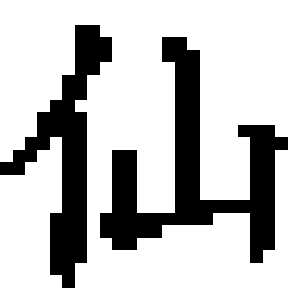

In [15]:
def et24code(w):
    """parse Eten Chinese 24 font to np.array"""
    a = np.frombuffer(w.encode('big5'), dtype='uint8')
    h, l = np.int32(a).reshape(-1, 2).T
    c = (h-161)*157 + l - np.where(l<161, 63, 97)
    return c - np.where(c<=5872, 472, 6281 )

f24 = np.fromfile('STDFONT.24K', dtype='uint8')
f24 = np.unpackbits(f24).reshape(-1, 24, 24)*255
f24 = np.repeat(f24[..., None], axis=3, repeats=3)
pixels = 255-f24[et24code("仙")].reshape(-1,24,3)
Image.fromarray(pixels).resize((300,300), Image.NEAREST)

In [16]:
X, y, palette = preprocess_image(pixels)
X_tensor, y_tensor = torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)
dataset = MyDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=X_tensor.shape[0], shuffle=False)

# 初始化模型、優化器和數據加載器
input_dim = X.shape[1]
num_classes = len(set(y))
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, net_width=64, dropout=False)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

In [17]:
train(model, dataloader, optimizer, num_classes=num_classes, num_epochs=3)

Epoch 1/3, Loss: 0.0349, Accuracy: 0.9850
Epoch 2/3, Loss: 0.0000, Accuracy: 1.0000
Epoch 3/3, Loss: 0.0000, Accuracy: 1.0000


Accuracy: 1.0000


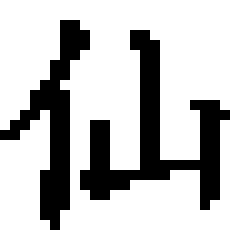

In [22]:
generate_predicted_image(model, X, y, palette, pixels)

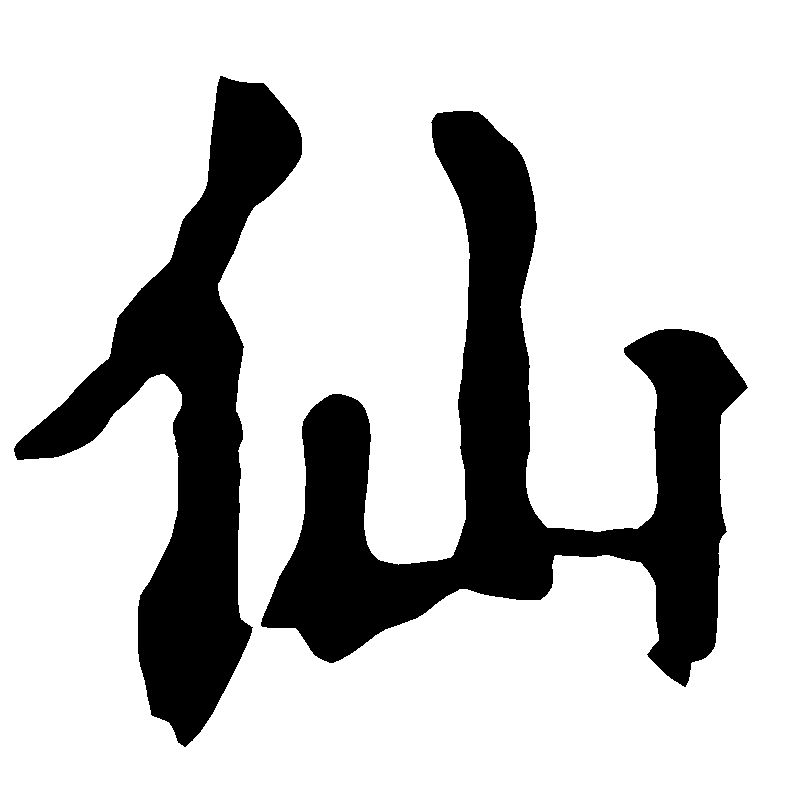

In [25]:
generate_high_res_image(model, X, palette)

In [26]:
def load_and_resize_image(image_path, new_size=(300, 300)):
    pixels = np.array(Image.open(image_path))
    # 獲取原始影像的高度和寬度
    h, w = pixels.shape[:2]
    
    # 調整影像大小
    image = Image.fromarray(pixels).resize(new_size, Image.NEAREST)
    
    return pixels, h, w, image

## 測試案例 1

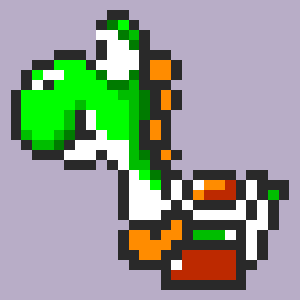

In [27]:
pixels, h, w, image = load_and_resize_image('img/smw_yoshi_input.png')

predicted_images = []
titles = []
high_res_images = []
image

### 僅使用 cross_entropy

In [28]:
X, y, palette = preprocess_image(pixels)
X_tensor, y_tensor = torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

dataset = MyDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=X_tensor.shape[0], shuffle=False)

# 初始化模型、優化器和數據加載器
input_dim = X.shape[1]
num_classes = len(set(y))
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, net_width=64)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

In [29]:
train(model, dataloader, optimizer, num_classes=num_classes, num_epochs=3)

Epoch 1/3, Loss: 0.1226, Accuracy: 0.9614
Epoch 2/3, Loss: 0.0019, Accuracy: 1.0000
Epoch 3/3, Loss: 0.0002, Accuracy: 1.0000


In [30]:
predicted_image1 = generate_predicted_image(model, X, y, palette, pixels)
high_res_image1 = generate_high_res_image(model, X, palette)

predicted_images.append(predicted_image1)
high_res_images.append(high_res_image1)
titles.append('cross_entropy')

Accuracy: 1.0000


### 使用 cross_entropy 加上 dropout

In [31]:
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, net_width=64, dropout=True)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

train(model, dataloader, optimizer, num_classes=num_classes, num_epochs=5)

Epoch 1/5, Loss: 0.3608, Accuracy: 0.8512
Epoch 2/5, Loss: 0.1634, Accuracy: 0.9320
Epoch 3/5, Loss: 0.1106, Accuracy: 0.9562
Epoch 4/5, Loss: 0.0823, Accuracy: 0.9682
Epoch 5/5, Loss: 0.0638, Accuracy: 0.9758


In [32]:
predicted_image2 = generate_predicted_image(model, X, y, palette, pixels)
high_res_image2 = generate_high_res_image(model, X, palette)

predicted_images.append(predicted_image2)
high_res_images.append(high_res_image2)
titles.append('cross_entropy + dropout')

Accuracy: 0.8821


### 使用 cross_entropy + SSIM

In [33]:
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, net_width=64)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

train_with_addtional_loss(model, dataloader, optimizer, num_classes, palette, pixels, h, w, num_epochs=3)

c:\Users\wei\Desktop\programs\NYCU Data Science\hw3\venv\Lib\site-packages\torchmetrics\utilities\prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(


Epoch 1/3, Loss: 0.1235, Accuracy: 0.9614
Epoch 2/3, Loss: 0.0027, Accuracy: 1.0000
Epoch 3/3, Loss: 0.0002, Accuracy: 1.0000


In [34]:
predicted_image3 = generate_predicted_image(model, X, y, palette, pixels)
high_res_image3 = generate_high_res_image(model, X, palette)

predicted_images.append(predicted_image3)
high_res_images.append(high_res_image3)
titles.append('cross_entropy + ssim')

Accuracy: 1.0000


### 使用 cross_entropy + dropout + SSIM

In [ ]:
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, net_width=64, dropout=True)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

train_with_addtional_loss(model, dataloader, optimizer, num_classes, palette, pixels, h, w, num_epochs=5)

Epoch 1/3, Loss: 0.3610, Accuracy: 0.8530
Epoch 2/3, Loss: 0.1525, Accuracy: 0.9380
Epoch 3/3, Loss: 0.1014, Accuracy: 0.9608


In [36]:
predicted_image4 = generate_predicted_image(model, X, y, palette, pixels)
high_res_image4 = generate_high_res_image(model, X, palette)

predicted_images.append(predicted_image4)
high_res_images.append(high_res_image4)
titles.append('cross_entropy + dropout + ssim')

Accuracy: 0.9345


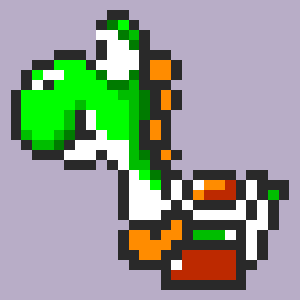

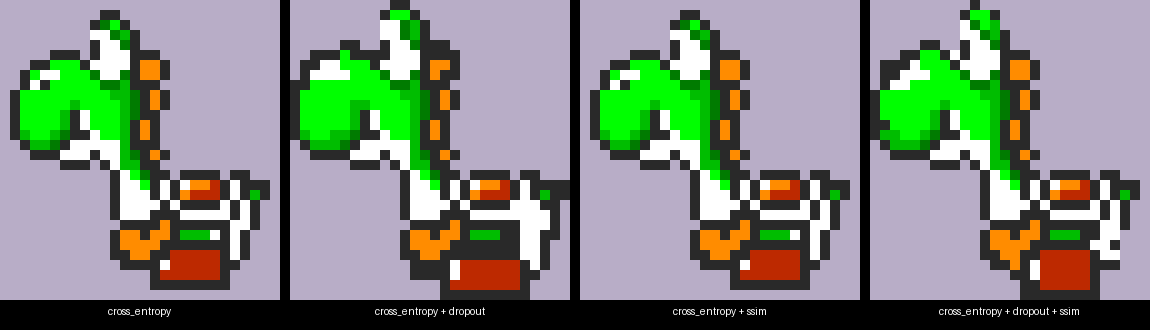

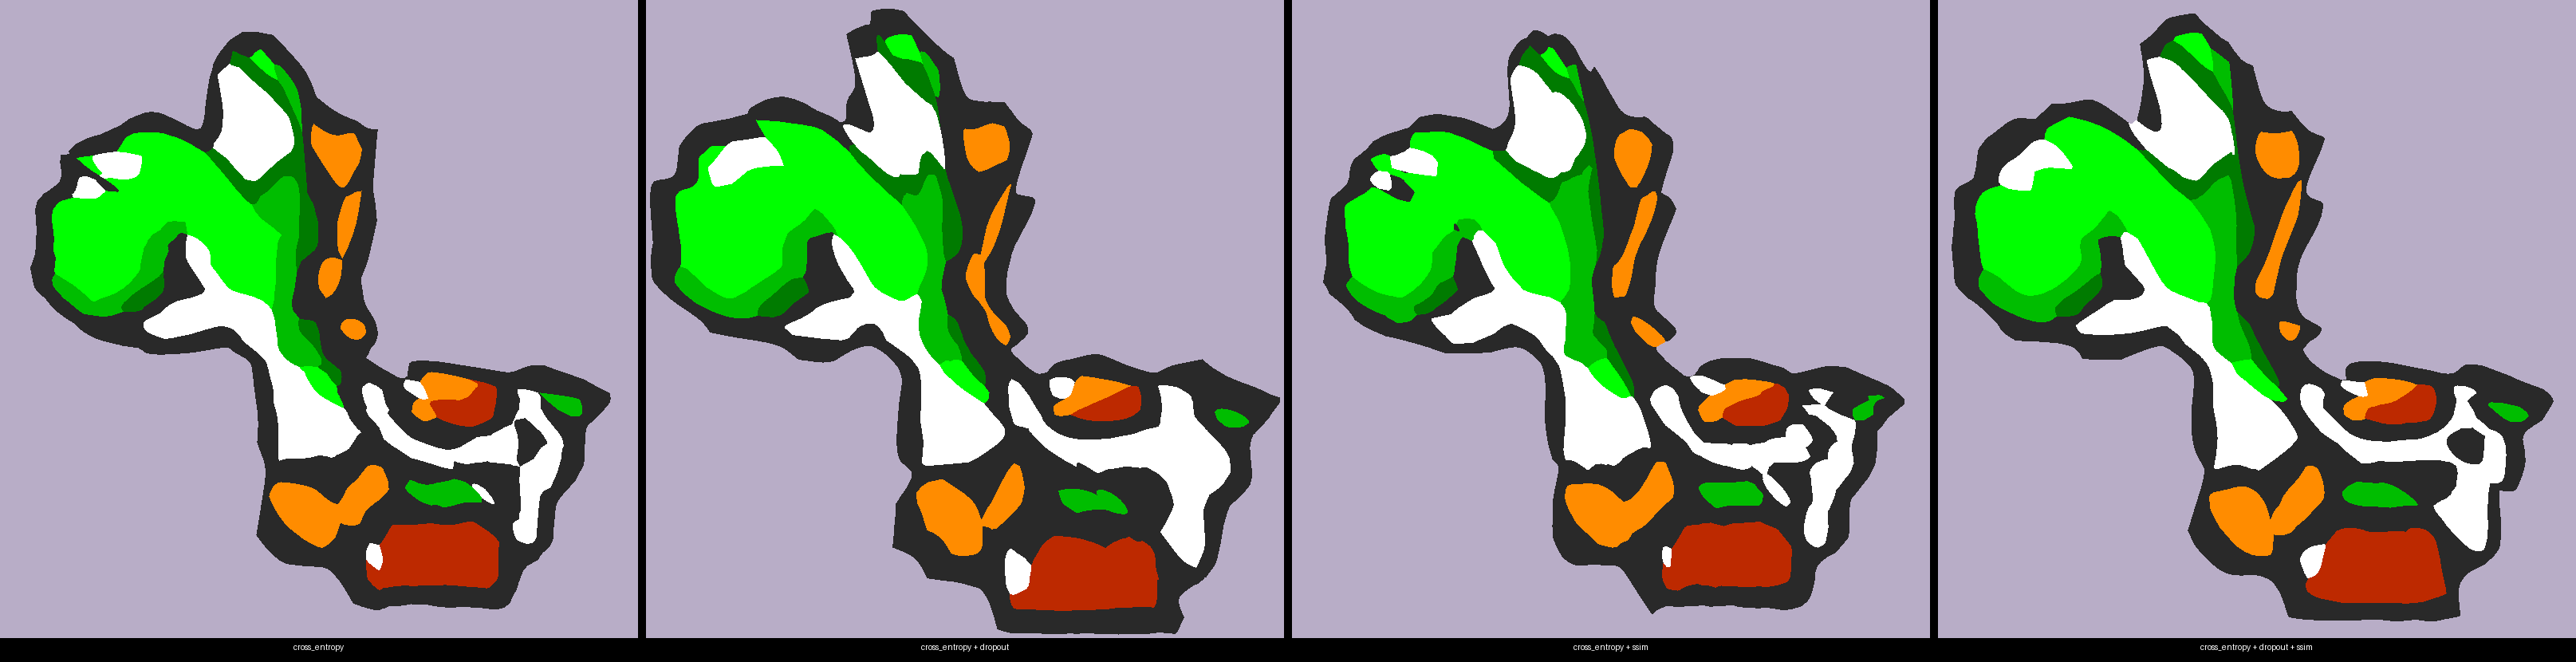

In [ ]:
display(image)
combine_images_horizontally(predicted_images, titles)
combine_images_horizontally(high_res_images, titles)


## 測試案例 2

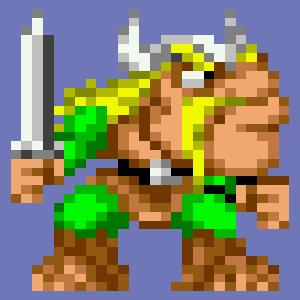

In [38]:
pixels, h, w, image = load_and_resize_image('img/vikings_baelog_input.png')
predicted_images = []
titles = []
high_res_images = []
image

### 僅使用 cross_entropy

In [39]:
X, y, palette = preprocess_image(pixels)
X_tensor, y_tensor = torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

dataset = MyDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=X_tensor.shape[0], shuffle=False)

# 初始化模型、優化器和數據加載器
input_dim = X.shape[1]
num_classes = len(set(y))
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, net_width=128)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

In [40]:
train(model, dataloader, optimizer, num_classes=num_classes, num_epochs=3)

Epoch 1/3, Loss: 0.2278, Accuracy: 0.9329
Epoch 2/3, Loss: 0.0044, Accuracy: 1.0000
Epoch 3/3, Loss: 0.0003, Accuracy: 1.0000


In [41]:
predicted_image1 = generate_predicted_image(model, X, y, palette, pixels)
high_res_image1 = generate_high_res_image(model, X, palette)

predicted_images.append(predicted_image1)
high_res_images.append(high_res_image1)
titles.append('cross_entropy')

Accuracy: 1.0000


### 使用 cross_entropy 加上 dropout

In [42]:
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, net_width=128, dropout=True)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

train(model, dataloader, optimizer, num_classes=num_classes, num_epochs=5)

Epoch 1/5, Loss: 0.6797, Accuracy: 0.7320
Epoch 2/5, Loss: 0.2803, Accuracy: 0.8876
Epoch 3/5, Loss: 0.1912, Accuracy: 0.9259
Epoch 4/5, Loss: 0.1485, Accuracy: 0.9441
Epoch 5/5, Loss: 0.1209, Accuracy: 0.9554


In [43]:
predicted_image2 = generate_predicted_image(model, X, y, palette, pixels)
high_res_image2 = generate_high_res_image(model, X, palette)

predicted_images.append(predicted_image2)
high_res_images.append(high_res_image2)
titles.append('cross_entropy + dropout')

Accuracy: 0.9737


### 使用 cross_entropy + K-means

In [44]:
background_color = pixels[0, 0]
background_color

array([111, 119, 185], dtype=uint8)

In [45]:
X, y, palette = preprocess_image_with_kmeans(pixels, n_clusters=12, background_color=background_color)
X_tensor, y_tensor = torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

dataset = MyDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=X_tensor.shape[0], shuffle=False)

# 初始化模型、優化器和數據加載器
input_dim = X.shape[1]
num_classes = len(set(y))
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, net_width=128)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

In [46]:
train(model, dataloader, optimizer, num_classes=num_classes, num_epochs=3)

Epoch 1/3, Loss: 0.2190, Accuracy: 0.9331
Epoch 2/3, Loss: 0.0173, Accuracy: 0.9986
Epoch 3/3, Loss: 0.0012, Accuracy: 1.0000


In [47]:
predicted_image3 = generate_predicted_image(model, X, y, palette, pixels)
high_res_image3 = generate_high_res_image(model, X, palette)

predicted_images.append(predicted_image3)
high_res_images.append(high_res_image3)
titles.append('cross_entropy + k-means')

Accuracy: 1.0000


### 使用 cross_entropy + dropout + k-means

In [48]:
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, net_width=128, dropout=True)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

train(model, dataloader, optimizer, num_classes=num_classes, num_epochs=3)

Epoch 1/3, Loss: 0.6717, Accuracy: 0.7310
Epoch 2/3, Loss: 0.2817, Accuracy: 0.8846
Epoch 3/3, Loss: 0.1915, Accuracy: 0.9246


In [49]:
predicted_image4 = generate_predicted_image(model, X, y, palette, pixels)
high_res_image4 = generate_high_res_image(model, X, palette)

predicted_images.append(predicted_image4)
high_res_images.append(high_res_image4)
titles.append('cross_entropy + dropout + k-means')

Accuracy: 0.9926


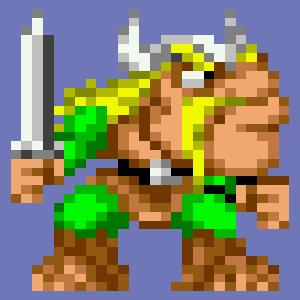

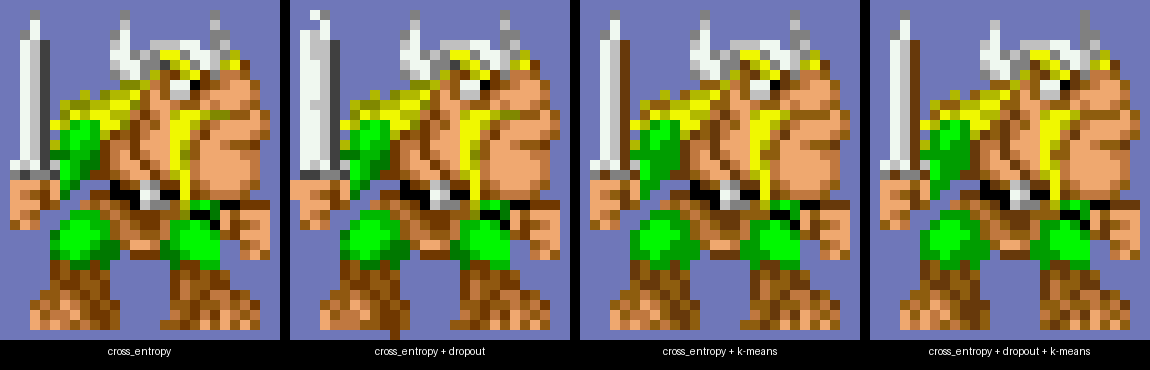

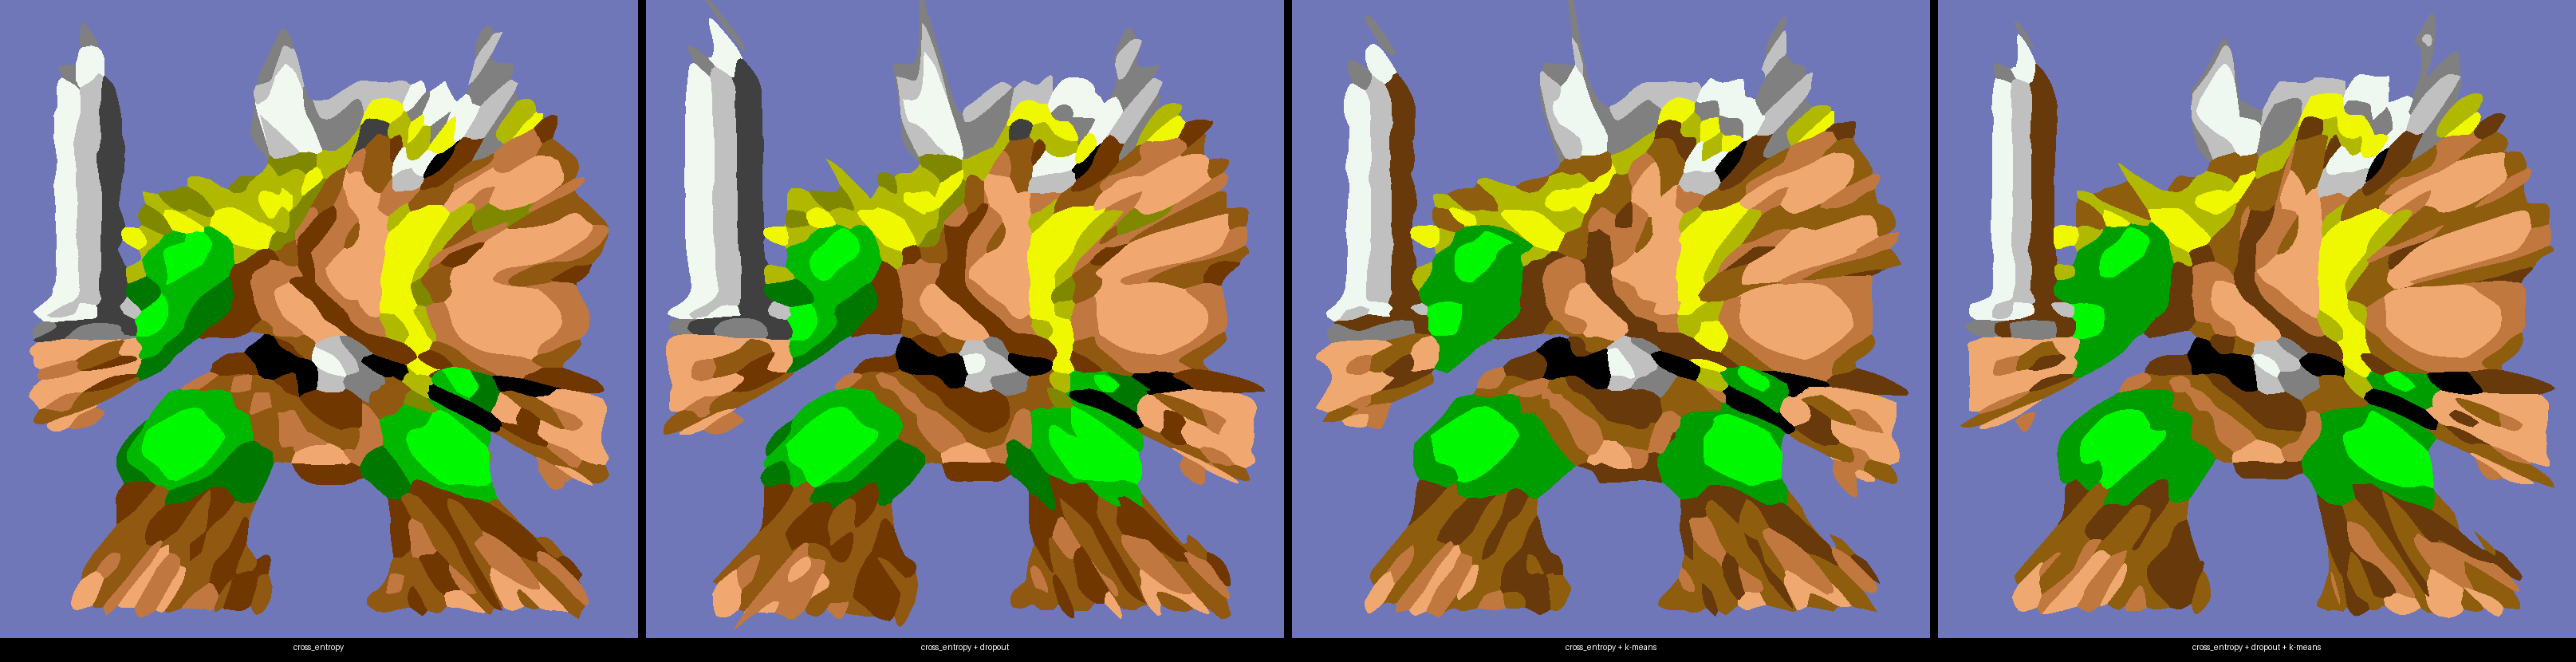

In [54]:
display(image)
combine_images_horizontally(predicted_images, titles)
combine_images_horizontally(high_res_images, titles)